<a href="https://colab.research.google.com/github/Ra-ha/Bangla_News_Categorization/blob/main/Bangla_Newspaper_Classification_USING_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/root/gdrive', force_remount=True)

Mounted at /root/gdrive


In [ ]:
%cd /root/gdrive/MyDrive/Bangla Newspaper classification

/root/gdrive/MyDrive/Bangla Newspaper classification


Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import Counter

Load data

In [ ]:
import json

with open('data.json', encoding='utf-8') as fh:
    orig_data = json.load(fh)
print(orig_data[0])

{'author': 'গাজীপুর প্রতিনিধি', 'category': 'bangladesh', 'category_bn': 'বাংলাদেশ', 'published_date': '০৪ জুলাই ২০১৩, ২৩:২৬', 'modification_date': '০৪ জুলাই ২০১৩, ২৩:২৭', 'tag': ['গাজীপুর'], 'comment_count': 0, 'title': 'কালিয়াকৈরে টিফিন খেয়ে ৫০০ শ্রমিক অসুস্থ, বিক্ষোভ', 'url': 'http://www.prothom-alo.com/bangladesh/article/19030', 'content': 'গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায় আজ বৃহস্পতিবার রাতের টিফিন খেয়ে একটি পোশাক কারখানার ৫০০ শ্রমিক অসুস্থ হয়ে পড়েছেন। এ ঘটনায় বিক্ষোভ করেছেন ওই কারখানার শ্রমিকেরা।সফিপুর মডার্ন হাসপাতালের জরুরি বিভাগের চিকিত্সক আল আমিন প্রথম আলো ডটকমকে বলেন, খাদ্যে বিষক্রিয়ায় তাঁরা (শ্রমিকেরা) অসুস্থ হয়ে পড়েছেন। এতে আতঙ্কিত হওয়ার কিছু নেই। অসুস্থদের চিকিত্সা দেওয়া হয়েছে।কারখানার শ্রমিক ও পুলিশ সূত্রে জানা যায়, উপজেলার তেলিরচালা এলাকার সেজাদ সোয়েটার লিমিটেড কারখানার শ্রমিকদের আজ রাত সাড়ে সাতটার দিকে টিফিন দেওয়া হয়। টিফিনে ছিল ডিম, রুটি, পেটিস ও কলা। টিফিন খেয়ে শ্রমিকেরা যথারীতি কাজে যোগ দেন। ওই টিফিন খাওয়ার প্রায় এক ঘণ্টা পর রাত সা

Trim data for test run

In [ ]:
data = orig_data[:23000]

Visualize data

In [ ]:
print("Total Rows:", len(data))
print("Total Cols:", len(data[0]))

Total Rows: 23000
Total Cols: 10


Show all columns

In [ ]:
print(type(data))
print("All columns:")
for col in data[0]:
  print(col)

<class 'list'>
All columns:
author
category
category_bn
published_date
modification_date
tag
comment_count
title
url
content


Retrieve all categories

In [ ]:
all_categories = set([sample['category'] for sample in data])
print(all_categories)
print(len(all_categories))

{'technology', 'onnoalo', 'we-are', 'kishoralo', 'sports', 'bangladesh', 'pachmisheli', 'facebook', '-1', 'entertainment', 'events', 'education', 'roshalo', 'opinion', 'economy', 'international', 'AskEditor', 'durporobash', 'life-style'}
19


test code

Sorting based on category count

In [ ]:
category_count_list = []
count = 0
for cat in all_categories:
  count = 0
  for row in data:
    if row['category'] == cat:
      count += 1
  category_count_list.append({'category': cat, 'count': count})
print(category_count_list)

from operator import itemgetter
sorted_cat_count_list = []
# sorted_cat_count_list = sorted(category_count_list, key=lambda x: x.count, reverse=True)
category_count_list.sort(key = itemgetter('count'), reverse=True)
print(category_count_list)

[{'category': 'technology', 'count': 1020}, {'category': 'onnoalo', 'count': 168}, {'category': 'we-are', 'count': 357}, {'category': 'kishoralo', 'count': 1}, {'category': 'sports', 'count': 2702}, {'category': 'bangladesh', 'count': 12226}, {'category': 'pachmisheli', 'count': 223}, {'category': 'facebook', 'count': 9}, {'category': '-1', 'count': 2}, {'category': 'entertainment', 'count': 1616}, {'category': 'events', 'count': 2}, {'category': 'education', 'count': 745}, {'category': 'roshalo', 'count': 142}, {'category': 'opinion', 'count': 752}, {'category': 'economy', 'count': 827}, {'category': 'international', 'count': 1763}, {'category': 'AskEditor', 'count': 1}, {'category': 'durporobash', 'count': 1}, {'category': 'life-style', 'count': 443}]
[{'category': 'bangladesh', 'count': 12226}, {'category': 'sports', 'count': 2702}, {'category': 'international', 'count': 1763}, {'category': 'entertainment', 'count': 1616}, {'category': 'technology', 'count': 1020}, {'category': 'eco

Discard low count catagories

In [ ]:
selected_cats = []

for p in category_count_list:
    if p['count'] > 300:
        selected_cats.append(p['category'])
print(selected_cats)
print(len(selected_cats))

['bangladesh', 'sports', 'international', 'entertainment', 'technology', 'economy', 'opinion', 'education', 'life-style', 'we-are']
10


Prepare data X, Y

In [ ]:
x_text = []
y_label = []

for row in data:
    if row['category'] in selected_cats:
        y_label.append(row['category'])
        x_text.append(row['content'])
print(len(x_text),len(y_label))


22451 22451


Split data into Train & test set

In [ ]:
X_test = x_text[0:5000]
y_test = y_label[0:5000]
X_train = x_text[5000:]
y_train = y_label[5000:]
print(len(X_train),len(X_test))

17451 5000


xlm Roberta

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
!pip install transformers
import transformers

     |████████████████████████████████| 3.8 MB 11.9 MB/s 
     |████████████████████████████████| 596 kB 11.2 MB/s 
     |████████████████████████████████| 6.6 MB 39.1 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 12.3 MB/s 


In [ ]:
from transformers import AutoTokenizer, TFAutoModel, TFXLMRobertaModel

bert_tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')
# bert_model = TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large")
bert_model = TFXLMRobertaModel.from_pretrained('jplu/tf-xlm-roberta-base')

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.76G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Tokenize x

In [ ]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = bert_tokenizer(
    text=X_train,
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = bert_tokenizer(
    text=X_test,
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

One hot encoding of Y

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
def make_ohe(y_label):
  # Label Encode
  encoder = LabelEncoder()
  class_labels = encoder.fit_transform(y_label)
  print(class_labels,len(class_labels),class_labels.shape)
  print(set(class_labels))

  #One hot Encode
  encoder = OneHotEncoder(sparse=False)
  class_labels = class_labels.reshape((class_labels.shape[0], 1))
  y_ohe = encoder.fit_transform(class_labels)
  print(y_ohe,y_ohe.shape)
  return y_ohe

In [ ]:
y_train = make_ohe(y_train)
print(type(y_train))

In [ ]:
y_test = make_ohe(y_test)
print(type(y_test))

In [ ]:
max_len = 512
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert_model(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# out = Dense(128, activation='relu')(out)
# out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(10,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tfxlm_roberta_model (TFXLMRobe  TFBaseModelOutputWi  278043648  ['input_ids[0][0]',              
 rtaModel)                      thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
# loss =CategoricalCrossentropy(from_logits = True)
# metrics = CategoricalAccuracy('balanced_accuracy'),
loss='categorical_crossentropy'
metrics=['accuracy']
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metrics)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('xlmRoberta_22k.h5', monitor='loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

In [ ]:
train_history = model.fit(x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']},validation_split=0.4,callbacks=[checkpoint, earlystopping],y= y_train, epochs=5, batch_size = 6)

Epoch 1/5
1745/1745 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.6130
Epoch 1: loss improved from inf to 1.35407, saving model to xlmRoberta_22k.h5
1745/1745 [==============================] - 3309s 2s/step - loss: 1.3541 - accuracy: 0.6130 - val_loss: 1.5649 - val_accuracy: 0.6321
Epoch 2/5
1745/1745 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.7812
Epoch 2: loss improved from 1.35407 to 0.73438, saving model to xlmRoberta_22k.h5
1745/1745 [==============================] - 3259s 2s/step - loss: 0.7344 - accuracy: 0.7812 - val_loss: 1.1132 - val_accuracy: 0.8048
Epoch 3/5
1745/1745 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.8452
Epoch 3: loss improved from 0.73438 to 0.54626, saving model to xlmRoberta_22k.h5
1745/1745 [==============================] - 3251s 2s/step - loss: 0.5463 - accuracy: 0.8452 - val_loss: 0.9574 - val_accuracy: 0.8161
Epoch 4/5
1745/1745 [==============================] - ETA: 0s

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


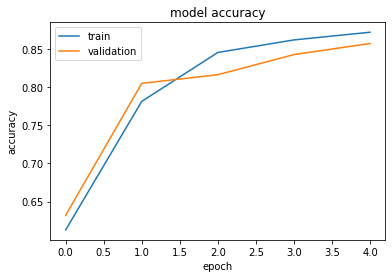

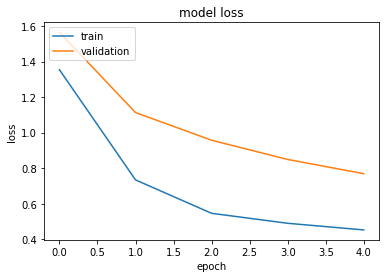

In [ ]:
# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save("xlmRoberta_22k.h5")

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Train accuracy

In [ ]:
predicted_raw_train = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw_train[0]

array([8.4868893e-03, 1.0969907e-02, 6.1140633e-03, 6.7531511e-02,
       4.0986720e-02, 5.0625694e-03, 1.4910587e-03, 1.7545404e-02,
       8.4147626e-01, 3.3553765e-04], dtype=float32)

In [ ]:
y_predicted_train = np.argmax(predicted_raw_train, axis = 1)
y_true_train = np.argmax(y_train, axis = 1)
print(classification_report(y_true_train, y_predicted_train))
print(confusion_matrix(y_true_train, y_predicted_train))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      9509
           1       0.53      0.80      0.63       622
           2       0.77      0.86      0.81       594
           3       0.83      0.90      0.86      1267
           4       0.72      0.88      0.79      1367
           5       0.77      0.56      0.65       337
           6       0.44      0.64      0.52       581
           7       0.97      0.94      0.96      2085
           8       0.88      0.77      0.82       790
           9       0.35      0.09      0.14       299

    accuracy                           0.86     17451
   macro avg       0.72      0.73      0.71     17451
weighted avg       0.88      0.86      0.87     17451

[[8558  301   45   67  275    1  214   15   23   10]
 [  97  495    2    1    9    0    5    1   12    0]
 [  27    4  512    5    2    0   38    4    0    2]
 [  30    0    3 1137   43    6   20   14    5    9]
 [  56   17    3   22 1208   

Test accuracy

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

array([0.48936749, 0.08851821, 0.04347318, 0.11170283, 0.1096868 ,
       0.00962446, 0.06273017, 0.04807385, 0.02228068, 0.01454228],
      dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(classification_report(y_true, y_predicted))
print(confusion_matrix(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2717
           1       0.47      0.75      0.57       205
           2       0.76      0.86      0.81       151
           3       0.82      0.86      0.84       349
           4       0.71      0.85      0.77       396
           5       0.85      0.54      0.66       106
           6       0.44      0.65      0.52       171
           7       0.96      0.95      0.96       617
           8       0.86      0.73      0.79       230
           9       0.47      0.12      0.19        58

    accuracy                           0.85      5000
   macro avg       0.73      0.72      0.70      5000
weighted avg       0.87      0.85      0.85      5000

[[2391  128   14   13   77    2   78    5    9    0]
 [  39  153    0    0    5    0    3    0    5    0]
 [   8    3  130    2    0    0    7    1    0    0]
 [   6    0    3  301   19    3    7    4    3    3]
 [  31    3    0    7  337   

Done

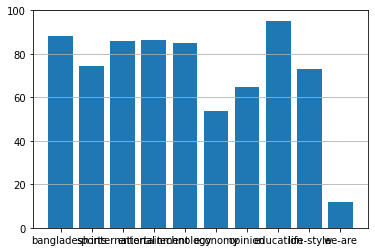

In [ ]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
arr = [[2391,128,14,13,77,2,78,5,9,0],
       [39,153,0,0,5,0,3,0,5,0],
       [8,3,130,2,0,0,7,1,0,0],
       [6,0,3,301,19,3,7,4,3,3],
       [31,3,0,7,337,0,10,0,6,2],
       [3,3,7,15,3,57,11,5,2,0],
       [14,18,8,2,13,1,111,1,1,2],
       [4,2,0,14,6,3,0,587,0,1],
       [13,19,5,5,17,0,2,1,168,0],
       [7,0,3,8,1,1,25,5,1,7]]

n = 10
x = ['bangladesh', 'sports', 'international', 'entertainment', 'technology', 'economy', 'opinion', 'education', 'life-style', 'we-are']
y = []
for i in range(n):
    p = arr[i][i]
    q = 0
    for j in range(n):
        q += arr[i][j]
    y.append(p * 100 / q)
        
plt.bar(x, y)
plt.ylim(0, 100)
plt.grid(axis = 'y')
plt.show()